The purpose of this notebook is to document data exploration processes with an n=50,000 sample of our Learn2Therm protein database. Doing so provides a workspace to select and optimize a model for predicting protein pair functionality between two sequences. Several classifier architectures were tested prior to the release of the final version of this component.

This notebook includes exploration of a Random Forest Classifier.

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import unittest

In [72]:
cd /Users/loganroberts/Learn2Therm/ValidProt/notebooks

/Users/loganroberts/Learn2Therm/ValidProt/notebooks


In [73]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k_exploration.csv')

In [74]:
hmmer_target = pd.read_csv('protein_match_50k')
hmmer_target['protein_match'] = hmmer_target['protein_match'].map({'Yes': 1, 'No': 0})
hmmer_target



from sklearn.utils import resample

# Assuming your data is in a pandas DataFrame called 'data'
# Separate the majority and minority classes
majority_class = hmmer_target[hmmer_target['protein_match'] == 1]
minority_class = hmmer_target[hmmer_target['protein_match'] == 0]

# Undersample the majority class to match the number of minority class samples
n_samples = len(minority_class)
undersampled_majority = resample(majority_class, n_samples=n_samples, replace=False)

# Combine the undersampled majority class with the minority class
balanced_data = pd.concat([undersampled_majority, minority_class])

balanced_data

df = pd.merge(df, balanced_data, on=['prot_pair_index'])
df.shape

(17108, 33)

In [75]:
df['protein_match'].value_counts()

1    8554
0    8554
Name: protein_match, dtype: int64

In [76]:
df['structure_match'] = df['protein_match']

In [77]:
df

,Unnamed: 0_x,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len,Unnamed: 0_y,protein_match,Jaccard_Score,structure_match
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202,0,1,1.000000,1
1,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269,3,1,1.000000,1
2,6,0.283582,0.231707,0.240506,133,0.810976,134,0.881579,99,7134,...,MGSTDRPDLAAMLAPLTRTLIAMERPVLETYGLTMWAYSVLVALSR...,MGHKDELIARIQRAEREFRRSVVSQAATDFFSVDLTMPQLRVVFFL...,MarR family transcriptional regulator,MarR family transcriptional regulator,152,164,6,1,1.000000,1
3,8,0.265306,0.201550,0.210243,320,0.826873,294,0.828169,140,1674,...,MSITTKEKRFGIIERYREFLPVTENTPKLTLHEGDTPLIHAASLSA...,MSGVEIEKGYFGQFGGSFVFPELQEVLDYLAEQFERYKDDPEFKQE...,threonine synthase,tryptophan synthase subunit beta,355,387,8,1,1.000000,1
4,10,0.334630,0.299652,0.299130,253,0.881533,256,0.888889,206,14963,...,MTLFVQQLANGLALGGIYCLAAIGLTLVFGVLGFPNLAHGALYMLG...,MSDFLQYLISGLAVGCGFALLASGLVTIHRVTHVVNFAQGMFAVVA...,branched-chain amino acid ABC transporter perm...,branched-chain amino acid ABC transporter perm...,288,287,10,1,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17103,49991,0.300000,0.300000,0.104803,80,1.000000,79,0.208995,104,4107,...,MKVLIIDDEKAMHLIMKRMLAKVADVEVVESFLETAPAFSYLANHE...,MKAIIVDDEPMTRSGLRRFVDWEGLGIEVAGEAEDGIEAYERFVQV...,response regulator,response regulator,378,80,4871,1,0.333333,1
17104,49995,0.344828,0.169972,0.192308,180,0.509915,200,0.738007,53,14963,...,MDNATFRLGDDLSVRLPGHSRWIGQVEREQRWLPWLAPRLPLTVST...,MPPQPRPLRPNDPREIGGFALLGRLGEGGQGTVYLGGAPDGRRVAV...,aminoglycoside phosphotransferase family protein,serine/threonine protein kinase,271,353,4875,0,0.250000,0
17105,49997,0.352174,0.239645,0.242152,230,0.680473,227,0.685801,279,7134,...,MIRLAELTKTYPGQQHPAVDGISMEVAEGEIVVLVGPSGCGKTTTL...,MTEQPILSARGLTVDFRLRGGRRARAVDGVDLDLAPGEVLALAGES...,ABC transporter ATP-binding protein,ABC transporter ATP-binding protein,331,338,4877,0,0.250000,0
17106,49998,0.334764,0.331915,0.329810,232,0.987234,230,0.966387,281,11324,...,MSESHAGALLSVRGLTAGYGGATALDGVSLTVAAGETVALLGANGA...,MSLLTTSGLTRHFSGIHAVEGVDFTLEAGEIRALIGSNGAGKTTLV...,ABC transporter ATP-binding protein,ABC transporter ATP-binding protein,238,235,4878,1,0.500000,1


In [78]:
df_seqs = df[['m_protein_seq', 't_protein_seq', 'prot_pair_index']]
df_seqs

,m_protein_seq,t_protein_seq,prot_pair_index
0,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,48641291
1,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,136708305
2,MGSTDRPDLAAMLAPLTRTLIAMERPVLETYGLTMWAYSVLVALSR...,MGHKDELIARIQRAEREFRRSVVSQAATDFFSVDLTMPQLRVVFFL...,24980629
3,MSITTKEKRFGIIERYREFLPVTENTPKLTLHEGDTPLIHAASLSA...,MSGVEIEKGYFGQFGGSFVFPELQEVLDYLAEQFERYKDDPEFKQE...,180139301
4,MTLFVQQLANGLALGGIYCLAAIGLTLVFGVLGFPNLAHGALYMLG...,MSDFLQYLISGLAVGCGFALLASGLVTIHRVTHVVNFAQGMFAVVA...,85953105
...,...,...,...
17103,MKVLIIDDEKAMHLIMKRMLAKVADVEVVESFLETAPAFSYLANHE...,MKAIIVDDEPMTRSGLRRFVDWEGLGIEVAGEAEDGIEAYERFVQV...,4681374
17104,MDNATFRLGDDLSVRLPGHSRWIGQVEREQRWLPWLAPRLPLTVST...,MPPQPRPLRPNDPREIGGFALLGRLGEGGQGTVYLGGAPDGRRVAV...,78849058
17105,MIRLAELTKTYPGQQHPAVDGISMEVAEGEIVVLVGPSGCGKTTTL...,MTEQPILSARGLTVDFRLRGGRRARAVDGVDLDLAPGEVLALAGES...,161110219
17106,MSESHAGALLSVRGLTAGYGGATALDGVSLTVAAGETVALLGANGA...,MSLLTTSGLTRHFSGIHAVEGVDFTLEAGEIRALIGSNGAGKTTLV...,74177185


In [79]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [80]:
df.columns

Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'meso_index', 'prot_pair_index', 'meso_protein_int_index',
       'thermo_protein_int_index', 'taxa_pair_index',
       'local_gap_compressed_percent_id_16s',
       'scaled_local_query_percent_id_16s',
       'scaled_local_symmetric_percent_id_16s', 'query_align_cov_16s',
       'subject_align_cov_16s', 'bit_score_16s', 'm_ogt', 't_ogt',
       'ogt_difference', 'm_protein_len', 't_protein_len', 'protein_match',
       'Jaccard_Score', 'structure_match'],
      dtype='object')

From pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with target. Let's remove them.

In [81]:
# sns.pairplot(df.sample(500),height = 4)

In [82]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [83]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match,Jaccard_Score,structure_match
count,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,1.710800e+04,...,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000
mean,0.335960,0.254207,0.246763,199.749766,0.760478,198.875789,0.731641,206.390519,8151.457330,9.168915e+07,...,0.904792,1060.500292,27.393149,51.562661,24.169511,277.264613,264.340133,0.500000,0.455235,0.500000
std,0.083039,0.100449,0.102609,59.839303,0.145881,60.176431,0.191291,161.014702,4609.513802,5.232882e+07,...,0.015275,75.661947,3.722314,3.822445,3.628175,62.922187,68.440077,0.500015,0.340461,0.500015
min,0.179012,0.081301,0.045977,23.000000,0.284553,23.000000,0.091575,35.000000,5.000000,8.557000e+03,...,0.880026,891.000000,7.000000,41.000000,20.000000,32.000000,27.000000,0.000000,0.000000,0.000000
25%,0.290323,0.193277,0.188552,167.000000,0.637789,166.000000,0.611562,108.000000,4162.000000,4.678179e+07,...,0.893249,1008.000000,27.500000,50.000000,22.000000,239.000000,227.000000,0.000000,0.200000,0.000000
50%,0.318681,0.233227,0.229226,207.000000,0.761317,207.000000,0.757455,178.000000,8142.000000,9.300390e+07,...,0.903417,1055.000000,28.000000,52.500000,24.500000,271.000000,261.000000,0.500000,0.320513,0.500000
75%,0.353659,0.282964,0.274194,231.000000,0.890688,230.000000,0.891566,245.000000,12205.000000,1.368311e+08,...,0.914689,1107.000000,30.000000,52.500000,24.500000,325.000000,315.000000,1.000000,0.750000,1.000000
max,0.985075,0.985075,0.985075,398.000000,1.000000,398.000000,1.000000,1675.000000,16345.000000,1.814866e+08,...,0.996439,1679.000000,40.000000,78.000000,56.000000,400.000000,400.000000,1.000000,1.000000,1.000000


Split data into dev and test, and then split that into train and validation.

In [84]:
#drop columns that don't exihibit signficant pearson correlation with bit_score

df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [85]:
df = df.drop(columns = ['Jaccard_Score'])


In [86]:
df.columns

Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'm_protein_len', 't_protein_len', 'protein_match',
       'structure_match'],
      dtype='object')

In [87]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(14541, 12)
(2567, 12)
(12359, 12)
(2182, 12)


In [88]:
#ID target and features, separate into separate arrays

target = [columns for columns in df[['protein_match', 'structure_match']]]
input_features = [columns for columns in df.drop(columns=['protein_match', 'structure_match'])]

In [89]:
input_features

['local_gap_compressed_percent_id',
 'scaled_local_query_percent_id',
 'scaled_local_symmetric_percent_id',
 'query_align_len',
 'query_align_cov',
 'subject_align_len',
 'subject_align_cov',
 'bit_score',
 'm_protein_len',
 't_protein_len']

In [90]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
['protein_match', 'structure_match']


In [91]:
#split X and y

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values
test_y = test[target].values

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(14541, 10) (2567, 10) (14541, 2) (2567, 2)


In [92]:
#same thing for training and validation data

train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values
val_y = val[target].values

Scale the data

In [93]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [94]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier()
model.fit(dev_X, dev_y)

RandomForestClassifier()

In [95]:
import joblib

In [96]:
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']

In [97]:
joblib.load('trained_model.pkl')

RandomForestClassifier()

Test the model, report relevant statistics

In [98]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
len(preds)

Model score is: 0.7666536813400857


2567

In [99]:
preds[65]

array([0, 0])

In [100]:
# Create a DataFrame with two new columns
preds_df = pd.DataFrame(preds, columns=['hmmer_pred', 'structure_pred'])

In [102]:
test['hmmer_pred'] = preds_df['hmmer_pred'].values
test['structure_pred'] = preds_df['structure_pred'].values

In [86]:
test['hmmer_strucutre_match'] = test['hmmer_pred'] == test['structure_pred']

In [102]:
test

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,m_protein_len,t_protein_len,protein_match,structure_match,hmmer_pred,structure_pred,both,hmmer_strucutre_match
2712,0.295359,0.286885,0.280000,233,0.954918,250,0.976562,240,256,244,1,1,1,1,True,True
3270,0.372549,0.277372,0.247557,215,0.784672,208,0.611765,275,340,274,1,1,0,0,True,True
4563,0.300000,0.251908,0.261386,225,0.858779,215,0.884774,196,243,262,0,0,0,0,True,True
8451,0.328859,0.281609,0.281609,151,0.867816,151,0.867816,130,174,174,1,1,1,1,True,True
14189,0.351438,0.310734,0.324484,344,0.971751,320,0.987654,220,324,354,1,1,1,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9973,0.324201,0.233553,0.266917,224,0.736842,223,0.978070,227,228,304,1,1,0,0,True,True
15223,0.276730,0.202765,0.199546,159,0.732719,172,0.767857,90,224,217,0,0,0,0,True,True
14453,0.326667,0.149390,0.138223,164,0.500000,148,0.388451,45,381,328,0,0,0,0,True,True
3105,0.328402,0.290576,0.294430,338,0.884817,335,0.900538,387,372,382,1,1,1,1,True,True


Convert the above code into functions.

In [24]:
def train_model(dataframe, columns = [],  target = []):
    """
    Takes dataframe and splits it into a training and testing set. 
    Note: Data is called train and test, but this test set is currently
    closer to a validation set. Keeping nomenclature to keep model robust.
    Trains a KNN classifier model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe 
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Sk-learn model object
    -train data (features)
    -train data (target)
    -validation data (features)
    -validation data (target)
    """
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.ensemble.RandomForestClassifier()
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y
    

In [25]:
model, dev_X, dev_y, test_X, test_y = train_model(df, columns = input_features, 
                                          target='protein_match')

In [42]:
class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_model([1,2,3], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
    
#     def test_input_distro(self):
        
#         #test that dev and test features have similar Jensen Shannon Distribution
        
#         JSD = (
#             scipy.stats.bootstrap((train_reg(split_data(df)[0], split_data(df)[1],
#                                 columns = input_features, target=target)[1], train_reg(split_data(df)[0], 
#                                 split_data(df)[1], columns = input_features, target=target)[3]), 
#                                   JSD_dev_and_test, n_resamples=1000, 
#                                   batch=5, method='percentile')
#         )

#         div = JSD.confidence_interval[1]
        
#         #asserts that the divergence between data sets is sufficiently low
#         assert abs(div) < 0.3, "Warning! High JSD between dev and test set!"
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_model(df, columns = input_features, 
                                          target = target)) == 5
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 4.490s

OK


In [43]:
#need to fix this

def evaluate_model(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    Vector of predictions based on the model (numpy array)
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    preds = model.predict(test_X)
    
    return preds

In [44]:
preds = evaluate_model(model, test_X, test_y)
preds

array([ True,  True,  True, ...,  True, False,  True])

In [45]:
class TestModelPerformance(unittest.TestCase):

    def test_asserts(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert that input types are correct
        with self.assertRaises(AssertionError):
            evaluate_model(model, [1, 2, 3], test_y)
            
    def test_model_output(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_pred_dimension(self):
        model, _, _, test_X, test_y = train_model(df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelPerformance)
_ = unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 13.083s

OK


A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [46]:
def plot_model(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = evaluate_model(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    
    return score
    

0.6423766816143498

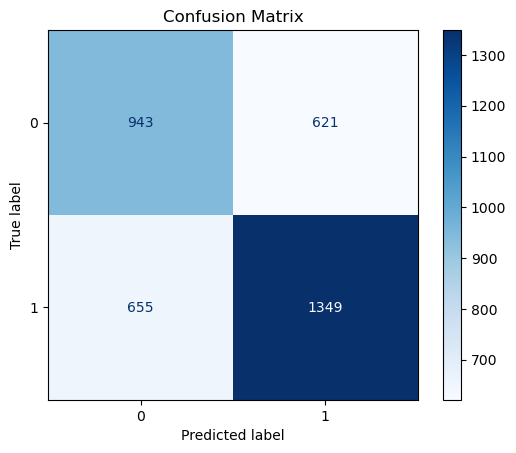

In [47]:
#make some appropriate display labels here

plot_model(model, test_X, test_y)

In [48]:
#wrapper function

def RF_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Target feature predictions
    -Parity plot
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 'protein_match'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_model(
                                        dataframe, columns=input_features, 
                                        target=target
                                                   )
    
    #test the model and return predictions
    preds = evaluate_model(model, test_X, test_y)

    #plot the results of the model
    plot_model(model, test_X, test_y)
    
    return preds

array([ True,  True,  True, ...,  True,  True,  True])

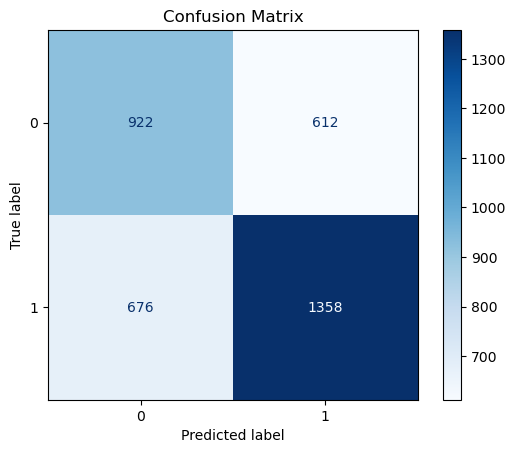

In [49]:
RF_wrapper(df)

In [50]:
class TestWrapper(unittest.TestCase):
    
    def test_wrapper_input(self):
        #test that input data type is correct
        try:
            RF_wrapper([1,2,3])
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)

    def test_wrapper_output(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_output_dimension(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestWrapper)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 9.203s

OK


**IGNORE BELOW**

In [35]:
# #plot empirical distribution of scaled_local_query_percent_id

# target = df['protein_match']
# #create histplot
# fig, ax = plt.subplots()

# sns.histplot(data = df, x = target)

# ax.set_title('Sample Histogram', fontsize=16)
# ax.set_xlabel('Class', fontsize=14)
# ax.set_ylabel('Count', fontsize=14)

Things I've tried to improve model: 

1. drop bit scores over 1000
2. Switch to 85/15 train/test split
3. Lasso regression - not great
4. Ridge regression - R2 = 0.87, about the same as normal Linear regression
5. KNN regression (n_neighbors optimized at 8) gives best result, R2 = ~0.93 --> 
*got it up to .942 by removing a few features
6. Decision tree regressor was slightly worse than KNN
7. Input DT classifier and RF classifier. RF classifier has best performance
8. Changed target to binary protein function match

In [105]:
number= 5.13

In [106]:
str(number)

'5.13'

In [107]:
number = 'number'

In [108]:
str(number)

'number'